### Libraries

In [2]:
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.autograd import Variable
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np
import seaborn as sns

### Requierment

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Import dataset

In [5]:
# Create a random input tensor
# input_tensor = torch.randn(1, 1, 8)  # (batch_size, channels, sequence_length)
input_tensor = torch.tensor([1,2,3,4,1.5]).unsqueeze(0).unsqueeze(0)
# Apply 1D average pooling
pool_size = 2
stride = 2
output_tensor = F.avg_pool1d(input_tensor, kernel_size=input_tensor.shape[-1], stride=1)

print("Input tensor shape:", input_tensor.shape)
print("Output tensor shape:", output_tensor.shape, '   ,   ',output_tensor)

Input tensor shape: torch.Size([1, 1, 5])
Output tensor shape: torch.Size([1, 1, 1])    ,    tensor([[[2.3000]]])


# Model

In [6]:
# Define the TransformerEncoderModel
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, nhead):
        super(TransformerEncoderModel, self).__init__()
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.embedding2 = nn.Linear(d_model, input_dim)
        encoder_layers = TransformerEncoderLayer(d_model=512, nhead=8,batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=6)

    def forward(self, x):
        x = self.embedding(x)
        # x = x.permute(1, 0, 2)  # Reshape to (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x)
        output = self.embedding2(x)

        # output = output.permute(1, 0, 2)  # Reshape back to (batch_size, seq_len, hidden_dim)
        return output


# Define the full model
class TimeSeriesEncoder(nn.Module):
    def __init__(self, input_dim, d_model, num_layers, nhead):
        super(TimeSeriesEncoder, self).__init__()
        self.encoder_layer1 = TransformerEncoderModel(input_dim+2, d_model, num_layers, nhead)
        self.encoder_layer2 = TransformerEncoderModel(input_dim+2, d_model, num_layers, nhead)
        self.encoder_layer3 = TransformerEncoderModel(input_dim+2, d_model, num_layers, nhead)


        self.fc0 = nn.Linear(input_dim, 2)
        self.fc1 = nn.Linear(8,64)
        self.fc2 = nn.Linear(64,1)
        # self.fc3 = nn.Linear(256,10)
        self.relu = nn.ReLU()




    def forward(self, x):
        # x: [seq_len, batch_size, input_size]
        x = torch.concat((x,self.fc0(x)),axis=-1)
        # print(x.shape)
        # print(x.shape,' qqqq ')

        x = self.encoder_layer1(x)
        x = self.encoder_layer2(x)
        encoding = self.encoder_layer3(x)

        # print(encoding.shape)
        # encoding: [seq_len, batch_size, hidden_size]
        # print(encoding.shape,' qqqq ')

        # Apply 1D average pooling
        encoding = F.avg_pool1d(encoding, kernel_size=encoding.shape[-1], stride=1).squeeze(-1)

        # encoding = encoding.reshape(encoding.shape[0],-1)
        encoding =  F.dropout(encoding, p=0.5, training=self.training)
        encoding = self.fc1(encoding)
        encoding = self.relu(encoding)
        encoding =  F.dropout(encoding, p=0.5, training=self.training)
        encoding = self.fc2(encoding)
        # encoding = self.relu(encoding)

        # encoding = self.fc3(encoding)


        return encoding

# d_model, num_layers, nhead

# Example usage
input_dim = 5  # Dimension of each time step in the time series
d_model = 512  # Hidden dimension of the transformer
num_layers = 6  # Number of transformer encoder layers
nhead = 8  # Number of attention heads


model = TimeSeriesEncoder(input_dim, d_model, num_layers, nhead).to(device=device)


In [7]:
encoder_layer = nn.TransformerEncoderLayer(d_model=512, nhead=8,batch_first=True)
transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
src = torch.rand(10, 33, 512)
out = transformer_encoder(src)
out.shape

torch.Size([10, 33, 512])

In [8]:
# Generate some dummy time series data

time_series = torch.randn(32, 8, 5).to(device=device)

# Pass the time series through the transformer encoder
encoded_time_series = model(time_series)    # shape (batch_size, seq_len, hidden_dim)
time_series.shape,encoded_time_series.shape

(torch.Size([32, 8, 5]), torch.Size([32, 1]))

# Prepare dataset

In [9]:
import pandas as pd

In [10]:
df = pd.read_excel('/content/drive/MyDrive/Data/RawData/US/top50_DowJones.xlsx')
df.head()

,Unnamed: 0,MA,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,CRM,Unnamed: 8,Unnamed: 9,...,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,ACN,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300
0,NaN,Open,High,Low,Close,Adj Close,Volume,Open,High,Low,...,Low,Close,Adj Close,Volume,Open,High,Low,Close,Adj Close,Volume
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02 00:00:00,152.009995,153.410004,151.119995,151.910004,147.16893,3168900,102.879997,104.699997,102.269997,...,57.82,58.790001,53.380829,10112800,153.5,154.100006,152.779999,153.839996,141.472977,3061900
3,2018-01-03 00:00:00,152.289993,153.979996,152.160004,153.820007,149.019333,3732400,104.900002,106.139999,104.620003,...,58.310001,58.919998,53.498871,5683700,152.990005,154.990005,152.990005,154.550003,142.125885,2064200
4,2018-01-04 00:00:00,154.539993,157.399994,154.320007,155.809998,150.94725,3247200,106,107.660004,105.769997,...,58.759998,58.82,53.40807,6240000,155,156.860001,154.770004,156.380005,143.808746,1777000


In [11]:
stock_names = [col for col in df.columns if col.split(':')[0] != 'Unnamed']
columns = []
remove_col = []
types = ['_Open'	,'_High'	,'_Low'	,'_Close','_AdjClose','_Volume']
for col in stock_names:
    for type_ in types:
        columns.append(col+type_)
        if type_ == '_Close':
            remove_col.append(col+type_)


In [12]:
df.head()

,Unnamed: 0,MA,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,CRM,Unnamed: 8,Unnamed: 9,...,Unnamed: 291,Unnamed: 292,Unnamed: 293,Unnamed: 294,ACN,Unnamed: 296,Unnamed: 297,Unnamed: 298,Unnamed: 299,Unnamed: 300
0,NaN,Open,High,Low,Close,Adj Close,Volume,Open,High,Low,...,Low,Close,Adj Close,Volume,Open,High,Low,Close,Adj Close,Volume
1,Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-02 00:00:00,152.009995,153.410004,151.119995,151.910004,147.16893,3168900,102.879997,104.699997,102.269997,...,57.82,58.790001,53.380829,10112800,153.5,154.100006,152.779999,153.839996,141.472977,3061900
3,2018-01-03 00:00:00,152.289993,153.979996,152.160004,153.820007,149.019333,3732400,104.900002,106.139999,104.620003,...,58.310001,58.919998,53.498871,5683700,152.990005,154.990005,152.990005,154.550003,142.125885,2064200
4,2018-01-04 00:00:00,154.539993,157.399994,154.320007,155.809998,150.94725,3247200,106,107.660004,105.769997,...,58.759998,58.82,53.40807,6240000,155,156.860001,154.770004,156.380005,143.808746,1777000


In [13]:
df = df.drop(0).drop(1).drop('Unnamed: 0',axis=1)
df.columns = columns
df = df.drop(remove_col,axis=1)
df.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose,MA_Volume,CRM_Open,CRM_High,CRM_Low,CRM_AdjClose,CRM_Volume,...,ABT_Open,ABT_High,ABT_Low,ABT_AdjClose,ABT_Volume,ACN_Open,ACN_High,ACN_Low,ACN_AdjClose,ACN_Volume
2,152.009995,153.410004,151.119995,147.16893,3168900,102.879997,104.699997,102.269997,104.410004,4669200,...,58.200001,59.200001,57.82,53.380829,10112800,153.5,154.100006,152.779999,141.472977,3061900
3,152.289993,153.979996,152.160004,149.019333,3732400,104.900002,106.139999,104.620003,105.290001,3888700,...,58.990002,59.02,58.310001,53.498871,5683700,152.990005,154.990005,152.990005,142.125885,2064200
4,154.539993,157.399994,154.320007,150.94725,3247200,106,107.660004,105.769997,106.68,4540200,...,59.5,59.599998,58.759998,53.40807,6240000,155,156.860001,154.770004,143.808746,1777000
5,156.199997,159.039993,156.190002,154.076416,2747700,107.760002,108.300003,107.199997,108.099998,3368400,...,59.040001,59.09,58.639999,53.562428,5836900,156.610001,157.720001,156.130005,144.995102,1597600
6,158.580002,160.479996,158.080002,154.542145,3143100,108,109.139999,107.57,108.860001,2933600,...,58.849998,58.98,58.529999,53.40807,5411500,157.369995,159.009995,156.839996,146.153763,2616900


In [14]:
df_return = df.pct_change().drop(2) + 5
df_return.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose,MA_Volume,CRM_Open,CRM_High,CRM_Low,CRM_AdjClose,CRM_Volume,...,ABT_Open,ABT_High,ABT_Low,ABT_AdjClose,ABT_Volume,ACN_Open,ACN_High,ACN_Low,ACN_AdjClose,ACN_Volume
3,5.001842,5.003715,5.006882,5.012573,5.177822,5.019635,5.013754,5.022978,5.008428,4.832841,...,5.013574,4.996959,5.008475,5.002211,4.562030,4.996678,5.005775,5.001375,5.004615,4.674157
4,5.014774,5.022211,5.014196,5.012937,4.870003,5.010486,5.014321,5.010992,5.013202,5.167537,...,5.008646,5.009827,5.007717,4.998303,5.097876,5.013138,5.012065,5.011635,5.011841,4.860866
5,5.010742,5.010419,5.012118,5.020730,4.846175,5.016604,5.005945,5.013520,5.013311,4.741906,...,4.992269,4.991443,4.997958,5.002890,4.935401,5.010387,5.005483,5.008787,5.008250,4.899043
6,5.015237,5.009054,5.012101,5.003023,5.143902,5.002227,5.007756,5.003452,5.007031,4.870918,...,4.996782,4.998138,4.998124,4.997118,4.927119,5.004853,5.008179,5.004547,5.007991,5.638020
7,5.006747,4.997694,5.002910,5.001444,4.818905,5.009259,5.001832,5.006321,5.002664,5.125682,...,5.004248,5.002035,4.997437,5.001700,5.379821,5.007181,5.003019,5.003889,5.003335,5.224617


In [15]:
df1 = df_return.iloc[:, :5]

In [16]:
df1.head()

,MA_Open,MA_High,MA_Low,MA_AdjClose,MA_Volume
3,5.001842,5.003715,5.006882,5.012573,5.177822
4,5.014774,5.022211,5.014196,5.012937,4.870003
5,5.010742,5.010419,5.012118,5.020730,4.846175
6,5.015237,5.009054,5.012101,5.003023,5.143902
7,5.006747,4.997694,5.002910,5.001444,4.818905


In [17]:
int(df1.shape[0]*0.7)

998

In [18]:
# Split the data into input and target sequences
train_input_seq = []
train_target_seq = []
test_input_seq = []
test_target_seq = []

seq_length = 8
pred_length = 1
train_test_boundary = int(df1.shape[0]*0.7)
df1 = df1.to_numpy()

for i in range(train_test_boundary - seq_length - pred_length):
    train_input_seq.append(df1[i:i+seq_length, :])
    train_target_seq.append(df1[i+seq_length:i+seq_length+pred_length, -2])


for i in range(train_test_boundary - seq_length - pred_length + 10, len(df1) - seq_length - pred_length):
    test_input_seq.append(df1[i:i+seq_length, :])
    test_target_seq.append(df1[i+seq_length:i+seq_length+pred_length, -2])

In [19]:
np.shape(train_input_seq),np.shape(train_target_seq)

((989, 8, 5), (989, 1))

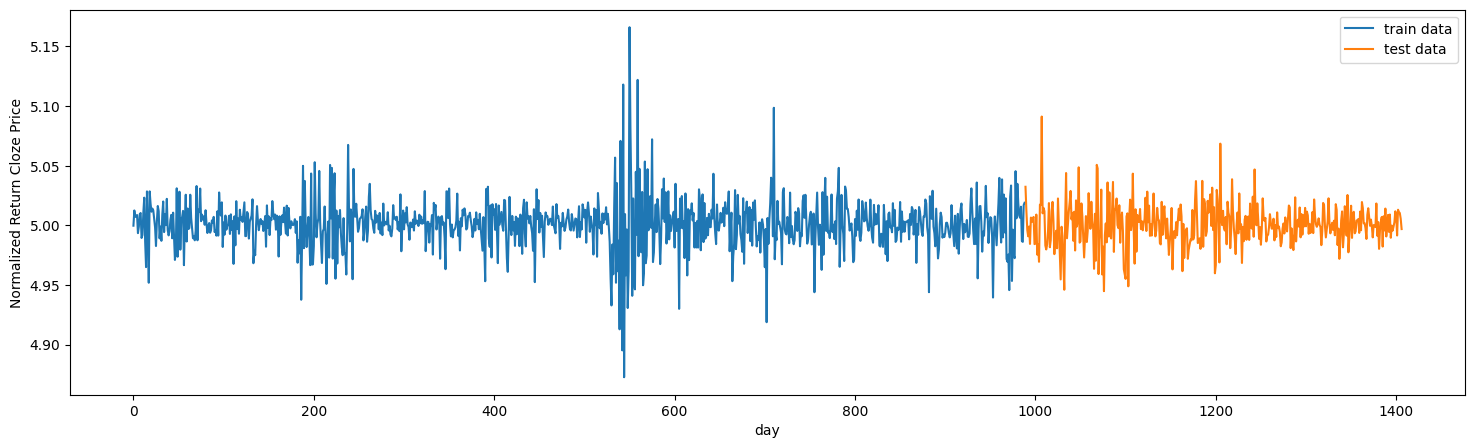

In [20]:
plt.figure(figsize=(18,5))
plt.plot(list(range(len(train_target_seq))), train_target_seq)
plt.plot(list(range(989,989+len(test_target_seq))),test_target_seq)
plt.xlabel('day')
plt.ylabel('Normalized Return Cloze Price')
plt.legend(['train data','test data']);

target $\rightarrow$ Adj close

In [21]:
train_input_seq = torch.tensor(train_input_seq)
train_target_seq = torch.tensor(train_target_seq)

test_input_seq = torch.tensor(test_input_seq)
test_target_seq = torch.tensor(test_target_seq)

<ipython-input-21-22edae8dc132>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_input_seq = torch.tensor(train_input_seq)


In [22]:
train_input_seq.shape , test_input_seq.shape

(torch.Size([989, 8, 5]), torch.Size([418, 8, 5]))

# Define the loss function and the optimizer :


In [23]:
num_epochs = 50
batch_size = 32  # paper
learning_rate = 0.0001

In [24]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
from torch.utils.data import DataLoader,Dataset
from tqdm import tqdm

# Define DataLoader :

In [26]:
class StockDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [27]:
dataset_train = StockDataset(train_input_seq, train_target_seq)
dataset_test = StockDataset(test_input_seq, test_target_seq)

In [28]:
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [29]:
for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
    print(targets.shape, "   <<>>   ",data.shape)

    if batch_idx == 10:
        break


 32%|███▏      | 10/31 [00:00<00:00, 312.22it/s]

torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])
torch.Size([32, 1])    <<>>    torch.Size([32, 8, 5])


In [30]:
model(torch.rand(32,8,5).to(device=device)).shape

torch.Size([32, 1])

In [31]:
len(train_dataloader)

31

# Train the model

In [32]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# Train Network
training_losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
        # Get data to cuda if possible
        data = data.to(device=device).float()
        targets = targets.to(device=device).float()

        # forward
        scores = model(data)#.unsqueeze(-1)
        loss = loss = criterion(scores, targets)

        #losses.append(loss.item())
        # backward
        optimizer.zero_grad()
        loss.backward()

        # gradient descent or adam step
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss# / len(train_dataloader)
    training_losses.append(epoch_loss)

    if (epoch+1) % 5 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))

<IPython.core.display.Javascript object>

100%|██████████| 31/31 [00:02<00:00, 14.60it/s]


Epoch [5/50], Loss: 84.2261


100%|██████████| 31/31 [00:02<00:00, 15.24it/s]


Epoch [10/50], Loss: 65.0353


100%|██████████| 31/31 [00:02<00:00, 15.31it/s]


Epoch [15/50], Loss: 56.0575


100%|██████████| 31/31 [00:02<00:00, 11.93it/s]


Epoch [20/50], Loss: 52.8658


100%|██████████| 31/31 [00:03<00:00,  9.33it/s]


Epoch [25/50], Loss: 49.4170


100%|██████████| 31/31 [00:02<00:00, 15.21it/s]


Epoch [30/50], Loss: 45.7837


100%|██████████| 31/31 [00:02<00:00, 15.45it/s]


Epoch [35/50], Loss: 45.1113


100%|██████████| 31/31 [00:02<00:00, 15.40it/s]


Epoch [40/50], Loss: 43.5500


100%|██████████| 31/31 [00:02<00:00, 14.27it/s]


Epoch [45/50], Loss: 42.6186


100%|██████████| 31/31 [00:02<00:00, 11.78it/s]

Epoch [50/50], Loss: 39.2932


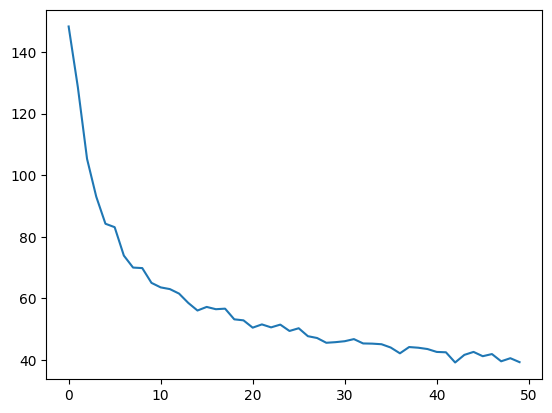

In [33]:
plt.plot(training_losses);

In [34]:
model.eval()

for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
    # Get data to cuda if possible
    data = data.to(device=device).float()
    targets = targets.to(device=device).float()

    # forward
    scores = torch.Tensor.detach(model(data).squeeze(1)).cpu().numpy()
    targets = torch.Tensor.detach(targets.squeeze(1)).cpu().numpy()

    if batch_idx == 0:
        train_preds = scores
        train_truth = targets
    else:
        train_preds = np.concatenate((train_preds,scores))
        train_truth = np.concatenate((train_truth,targets))




100%|██████████| 31/31 [00:00<00:00, 34.75it/s]


# Evaluation :

In [35]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

# for epoch in range(num_epochs):
model.eval()

for batch_idx, (data, targets) in enumerate(tqdm(test_dataloader)):
    # Get data to cuda if possible
    data = data.to(device=device).float()
    targets = targets.to(device=device).float()

    # forward
    scores = torch.Tensor.detach(model(data).squeeze(1)).cpu().numpy()
    targets = torch.Tensor.detach(targets.squeeze(1)).cpu().numpy()

    # print(scores.shape,"************",targets.shape)
    if batch_idx == 0:
        preds = scores
        truth = targets
    else:
        preds = np.concatenate((preds,scores))
        truth = np.concatenate((truth,targets))


    running_loss += loss.item()

# test_loss = running_loss / len(train_dataloader)
# training_losses.append(epoch_loss)


<IPython.core.display.Javascript object>

100%|██████████| 14/14 [00:00<00:00, 40.92it/s]


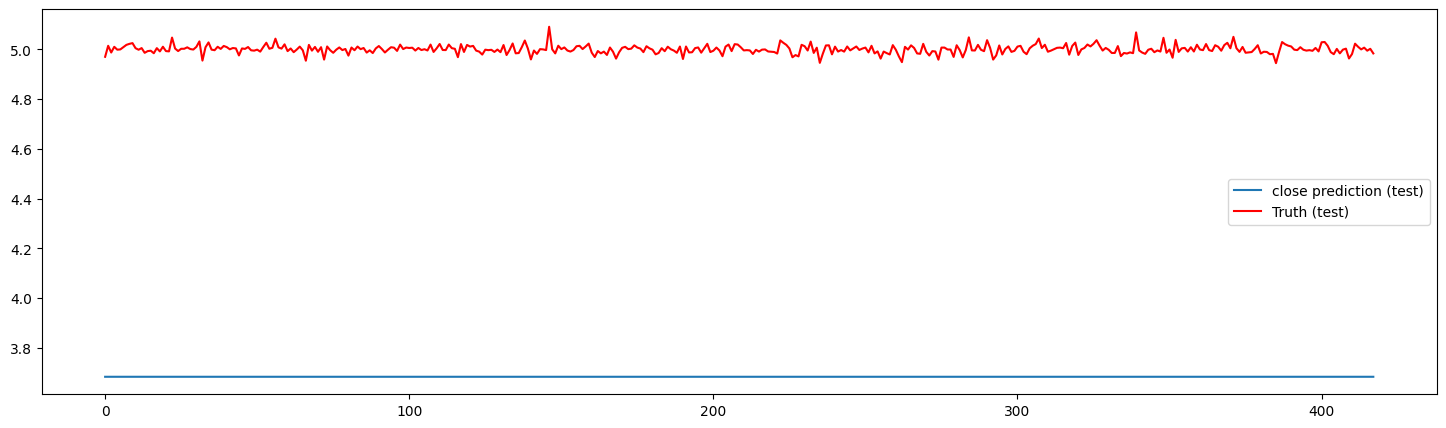

In [36]:
plt.figure(figsize=(18,5))
plt.plot(preds)
plt.plot(truth,color='r')
plt.legend(['close prediction (test)','Truth (test)']);

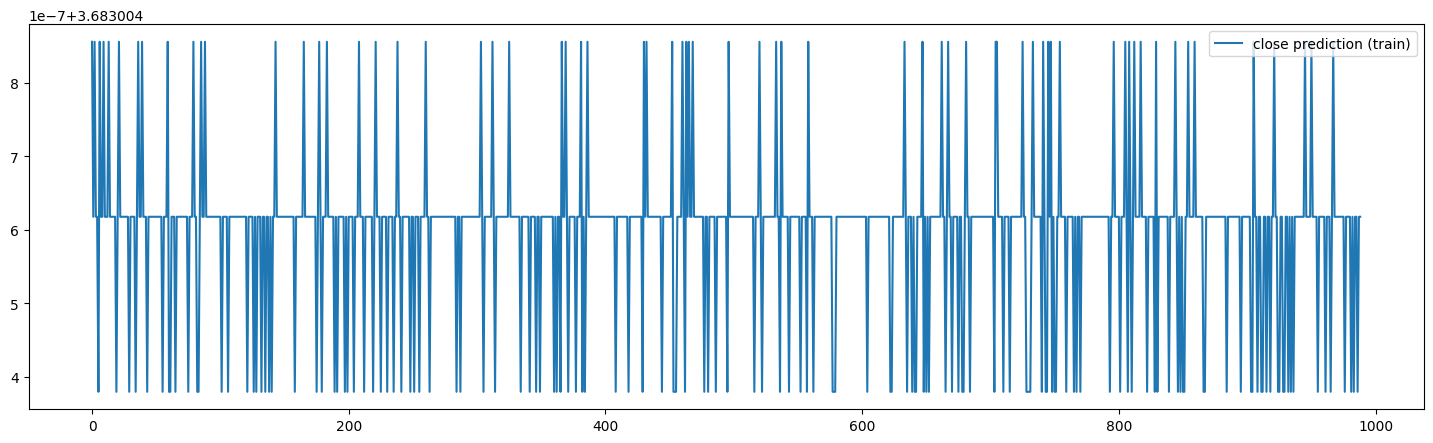

In [37]:
plt.figure(figsize=(18,5))
plt.plot(train_preds)
plt.legend(['close prediction (train)','Truth (train)']);

In [38]:
for batch_idx, (data, targets) in enumerate(tqdm(train_dataloader)):
    # Get data to cuda if possible
    data = data.to(device=device).float()
    targets = targets.to(device=device).float()
    if batch_idx ==0:

      print(data[0].shape,targets[0].shape)
      print(data[0],targets[0])
      a = data[21]


100%|██████████| 31/31 [00:00<00:00, 887.52it/s]

torch.Size([8, 5]) torch.Size([1])
tensor([[5.0237, 5.0001, 5.0088, 4.9899, 4.7057],
        [4.9935, 5.0117, 5.0095, 5.0259, 5.0563],
        [5.0255, 5.0200, 5.0133, 4.9941, 4.9934],
        [4.9990, 4.9998, 5.0037, 5.0227, 5.0588],
        [4.9858, 4.9917, 4.9702, 4.9719, 6.3601],
        [5.0032, 4.9850, 4.9811, 4.9695, 4.5571],
        [4.9592, 4.9563, 4.9842, 4.9756, 5.0645],
        [4.9821, 4.9851, 4.9429, 4.9458, 5.6360]], device='cuda:0') tensor([5.0240], device='cuda:0')


In [39]:
# model(a)
model(a.unsqueeze(0))

tensor([[3.6830]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
running_loss